In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import librosa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from PIL import Image
import pathlib
import csv
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import keras
from keras import layers
from keras import layers
import keras
from keras.models import Sequential
import warnings
warnings.filterwarnings('ignore')

from keras import layers
from keras.layers import Activation, Dense, Dropout, Conv2D, Flatten, MaxPooling2D, GlobalMaxPooling2D, GlobalAveragePooling1D, AveragePooling2D, Input, Add
from keras.models import Sequential
from keras.optimizers import SGD, Adam

from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import AveragePooling2D
from tensorflow.keras.layers import Dense, GRU, Bidirectional, LSTM
from keras.applications import VGG19 #For Transfer Learning

In [3]:
!pip install split_folders

In [4]:
import splitfolders
# To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
splitfolders.ratio('/kaggle/input/waveplot-balanced/img_waveplot_balanced', output="./data", seed=1337, ratio=(.8, .2)) # default values

Copying files: 8265 files [00:57, 142.92 files/s]


In [5]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
        rescale=1./255, # rescale all pixel values from 0-255, so aftre this step all our pixel values are in range (0,1)
#         shear_range=0.2, #to apply some random tranfromations
        zoom_range=0.2) #to apply zoom

test_datagen = ImageDataGenerator(
        rescale=1./255, # rescale all pixel values from 0-255, so aftre this step all our pixel values are in range (0,1)
#         shear_range=0.2, #to apply some random tranfromations
        zoom_range=0.2) #to apply zoom

In [6]:
training_set = train_datagen.flow_from_directory(
        './data/train',
        target_size=(256, 256),
        batch_size=32,
        class_mode='categorical',
        shuffle = True)

test_set = test_datagen.flow_from_directory(
        './data/val',
        target_size=(256, 256),
        batch_size=32,
        class_mode='categorical',
        shuffle = True )

num_classes = 5

Found 6610 images belonging to 5 classes.
Found 1655 images belonging to 5 classes.


Transfer Learning on VGG19

In [7]:
#Learning Rate Annealer
lrr= keras.callbacks.ReduceLROnPlateau(monitor='val_acc', factor=.01, patience=3, min_lr=1e-4)

In [8]:
#Defining the VGG Convolutional Neural Net
base_model = VGG19(include_top = False, weights = 'imagenet', input_shape = (256, 256, 3), classes = num_classes)

80142336/80134624 [==============================] - 1s 0us/step


In [9]:
#Adding the final layers to the above base models where the actual classification is done in the dense layers
model= Sequential()
model.add(base_model) 
model.add(Flatten()) 

In [10]:
#Model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 8, 8, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
Total params: 20,024,384
Trainable params: 20,024,384
Non-trainable params: 0
_________________________________________________________________


In [11]:
#Adding the Dense layers along with activation and batch normalization
model.add(Dense(1024,activation=('relu'),input_dim=512))
model.add(Dense(512,activation=('relu'))) 
model.add(Dense(256,activation=('relu'))) 
model.add(Dropout(.3))
model.add(Dense(128,activation=('relu')))
#model.add(Dropout(.2))
model.add(Dense(5,activation=('softmax'))) 

#Checking the final model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 8, 8, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              33555456  
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               3

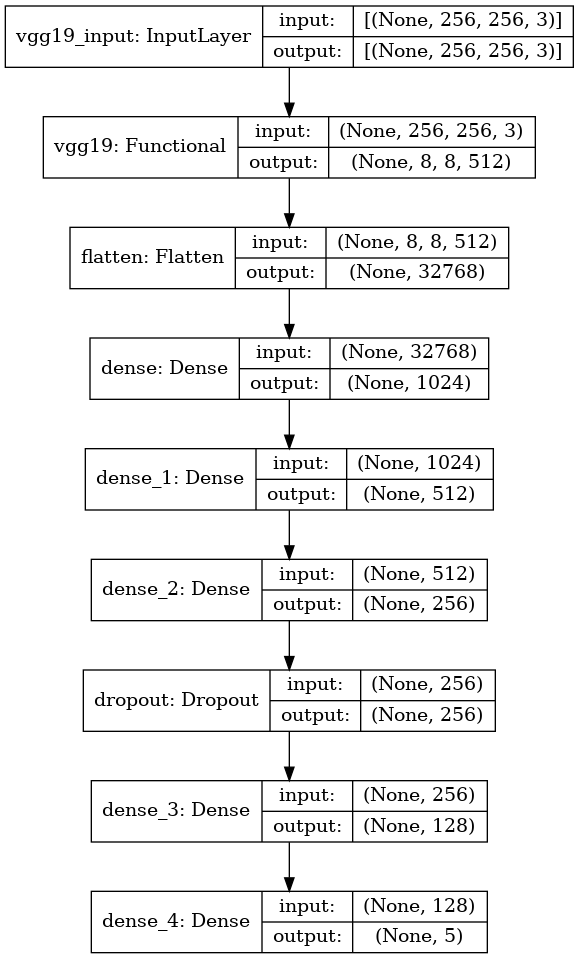

In [12]:
keras.utils.plot_model(model, show_shapes=True)

In [13]:
#Initializing the hyperparameters
batch_size= 100
epochs=120
learn_rate=0.001
sgd=SGD(lr=learn_rate,momentum=.9,nesterov=False)
adam=Adam(lr=learn_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer=sgd,loss='categorical_crossentropy',metrics=['accuracy', 'mse', 'AUC', 'Precision', 'Recall'])

In [16]:
#Training the model

history = model.fit_generator(
        training_set,
        steps_per_epoch=100,
        epochs=120,
        callbacks=lrr,
        verbose = 1,
        validation_data=test_set,
        validation_steps=200)

# model.fit_generator(train_generator.flow(x_train, y_train, batch_siz e= batch_size),epochs = epochs, steps_per_epoch = x_train.shape[0]//batch_size, validation_data = val_generator.flow(x_val, y_val, batch_size = batch_size), validation_steps = 250, callbacks=[lrr], verbose = 1)

Epoch 1/120
100/100 [==============================] - 99s 995ms/step - loss: 0.2807 - accuracy: 0.8497 - mse: 0.0364 - auc: 0.9873 - precision: 0.8524 - recall: 0.8444 - val_loss: 0.8347 - val_accuracy: 0.6640 - val_mse: 0.0903 - val_auc: 0.9326 - val_precision: 0.6723 - val_recall: 0.6532
Epoch 2/120
100/100 [==============================] - 99s 990ms/step - loss: 0.2743 - accuracy: 0.8603 - mse: 0.0355 - auc: 0.9877 - precision: 0.8646 - recall: 0.8575 - val_loss: 0.9252 - val_accuracy: 0.6695 - val_mse: 0.0950 - val_auc: 0.9246 - val_precision: 0.6793 - val_recall: 0.6628
Epoch 3/120
100/100 [==============================] - 98s 981ms/step - loss: 0.2714 - accuracy: 0.8572 - mse: 0.0352 - auc: 0.9878 - precision: 0.8603 - recall: 0.8509 - val_loss: 0.8918 - val_accuracy: 0.6592 - val_mse: 0.0936 - val_auc: 0.9240 - val_precision: 0.6677 - val_recall: 0.6508
Epoch 4/120
100/100 [==============================] - 100s 999ms/step - loss: 0.2770 - accuracy: 0.8603 - mse: 0.0354 - auc

KeyboardInterrupt: 

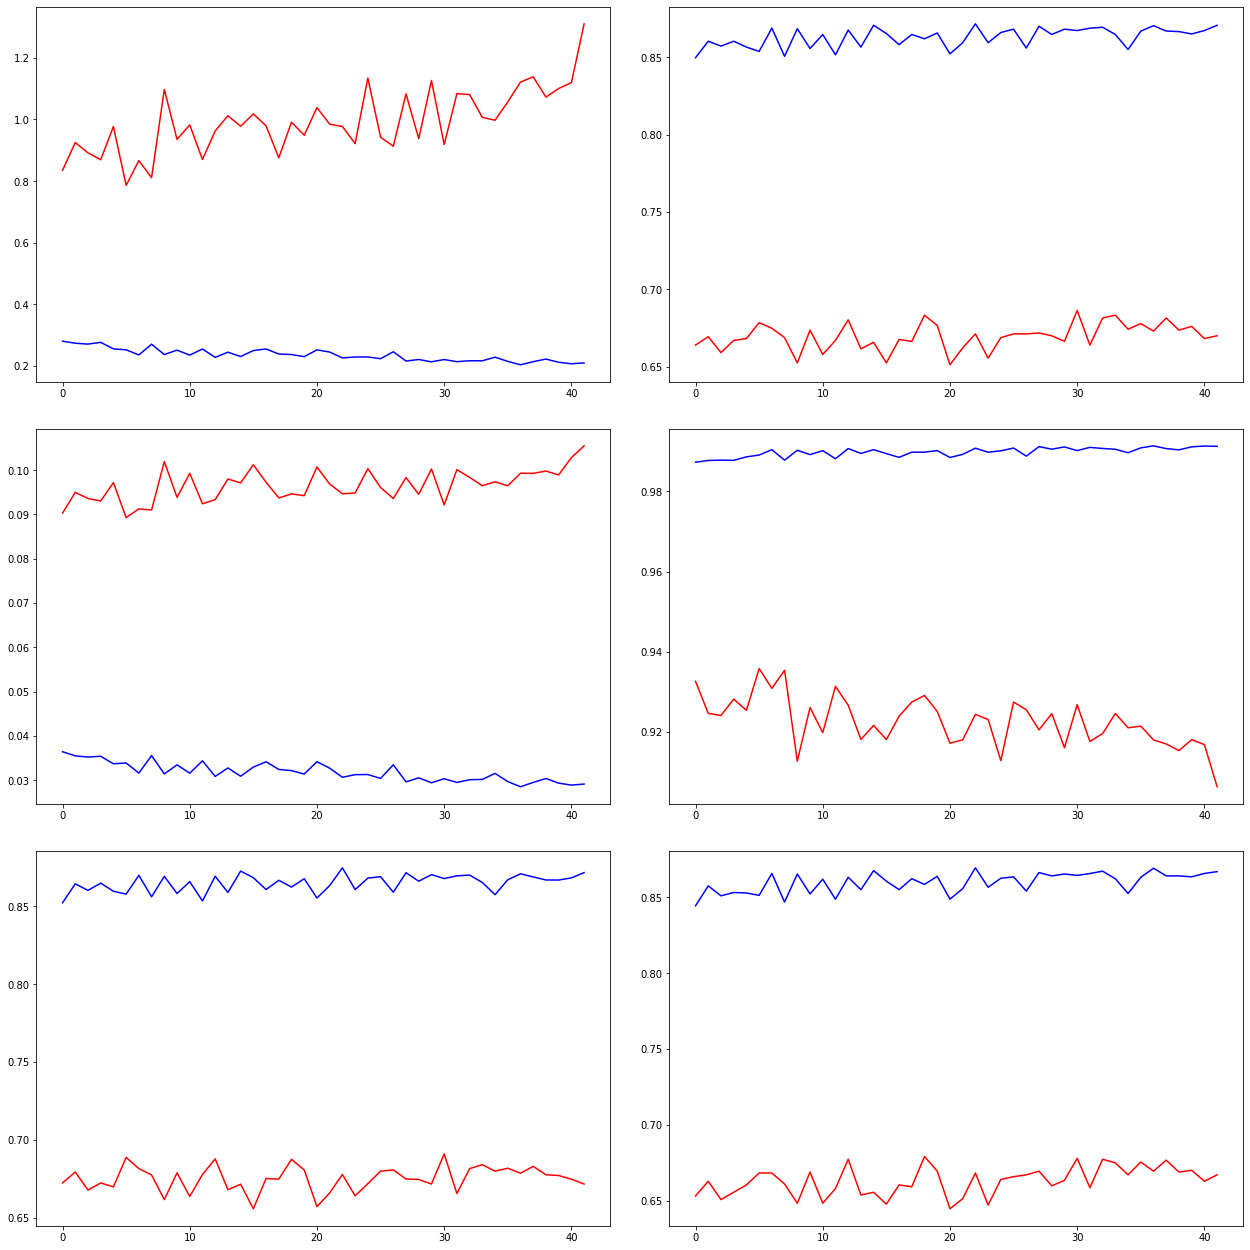

In [17]:
#Plotting the training and validation loss and accuracy

f, ax=plt.subplots(3,2, figsize=(18,18)) 

#Loss
ax[0][0].plot(model.history.history['loss'],color='b',label='Training Loss')
ax[0][0].plot(model.history.history['val_loss'],color='r',label='Validation Loss')

#Accuracy
ax[0][1].plot(model.history.history['accuracy'],color='b',label='Training  Accuracy')
ax[0][1].plot(model.history.history['val_accuracy'],color='r',label='Validation Accuracy')

#MSE
ax[1][0].plot(model.history.history['mse'],color='b',label='Training  MSE')
ax[1][0].plot(model.history.history['val_mse'],color='r',label='Validation MSE')

#AUC
ax[1][1].plot(model.history.history['auc'],color='b',label='Training  AUC')
ax[1][1].plot(model.history.history['val_auc'],color='r',label='Validation AUC')

#Precision
ax[2][0].plot(model.history.history['precision'],color='b',label='Training  Precision')
ax[2][0].plot(model.history.history['val_precision'],color='r',label='Validation Precision')

#Recall
ax[2][1].plot(model.history.history['recall'],color='b',label='Training  Recall')
ax[2][1].plot(model.history.history['val_recall'],color='r',label='Validation Recall')

f.tight_layout(pad=3.0)

In [18]:
filenames = test_set.filenames
nb_samples = len(filenames)

In [19]:
#Model Evaluation
model.evaluate_generator(generator=test_set, steps=nb_samples, callbacks = lrr)#OUTPUT

[1.1000505685806274,
 0.6755287051200867,
 0.09960968047380447,
 0.9186999201774597,
 0.6774193644523621,
 0.6725075244903564]

In [20]:
# test_set.reset()
pred = model.predict_generator(test_set, steps=nb_samples, verbose=1)

1655/1655 [==============================] - 31s 18ms/step


In [21]:
# Get most likely class
predicted_classes = np.argmax(pred, axis=1)

In [22]:
true_classes = test_set.classes
class_labels = list(test_set.class_indices.keys())

In [23]:
from sklearn import metrics
report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

              precision    recall  f1-score   support

  aggressive       0.20      0.21      0.21       331
    dramatic       0.20      0.20      0.20       331
       happy       0.19      0.18      0.18       331
    romantic       0.19      0.21      0.19       331
         sad       0.20      0.18      0.19       331

    accuracy                           0.20      1655
   macro avg       0.20      0.20      0.20      1655
weighted avg       0.20      0.20      0.20      1655



In [24]:
conf_matrix = metrics.confusion_matrix(y_true = true_classes, y_pred = predicted_classes, labels=[0,1,2,3,4])
print(conf_matrix)

[[71 73 52 78 57]
 [77 65 63 68 58]
 [65 64 59 79 64]
 [64 62 71 68 66]
 [71 54 71 74 61]]


In [25]:
cm_df = pd.DataFrame(conf_matrix,
                     index = ['Aggressive','Dramatic','Happy', 'Romantic', 'Sad'], 
                     columns = ['Aggressive','Dramatic','Happy', 'Romantic', 'Sad'])

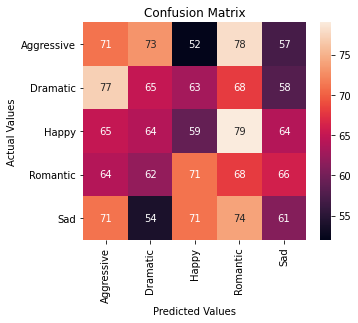

In [26]:
import seaborn as sns
#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

For aggressive:

TP = 64
TN = 1053
FP = 271
FN = 267

Precision = TP/(TP+FP) = 64/(335) = 0.19

Recall = TP/(TP+FN) = 64/(341) = 0.19

F1-score = 2.Precision.Recall/(Precision+Recall) = 0.19